In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from pdb import set_trace as breakpoint
from time import time

import numpy as np
import matplotlib.pyplot as plt

from datasets.generators1d import * 
from datasets.settings import OMEGA, MU0, EPSILON0, SCALE, C, L0, PIXEL_SIZE
from models.utils import pbar, tensor_diff, tensor_roll

In [2]:
device = torch.device('cuda:0')

In [3]:
class MaxwellDense(nn.Module):
    
    def __init__(self, size=64, src_x=32, num_layers=10, supervised=False, drop_p=0.1):
        super().__init__()
        
        self.size = size
        self.src_x = src_x
        self.num_layers = num_layers
        self.supervised = supervised
        self.drop_p = drop_p

        self.layer_dims = [2*self.num_layers, 128, 256, 256, 256, 128, self.num_layers]

        layers_amp = []
        layers_phi = []
        for i in range(len(self.layer_dims) - 1):
            layers_amp.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            layers_phi.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            
        self.layers_amp = nn.ModuleList(layers_amp)
        self.layers_phi = nn.ModuleList(layers_phi)
        
    def forward_amplitude_phase(self, x):
        A = x
        imax = len(self.layers_amp) - 1
        for i, layer in enumerate(self.layers_amp):
            A = layer(A)
            if i < imax:
                A = nn.ReLU()(A)
                A = nn.Dropout(p=self.drop_p)(A)
            else:
                A = nn.ELU()(A) + 1 + 0.1
                
        phi = x
        imax = len(self.layers_phi) - 1
        for i, layer in enumerate(self.layers_phi):
            phi = layer(phi)
            if i < imax:
                phi = nn.ReLU()(phi)
                phi = nn.Dropout(p=0.05)(phi)
            else:
                phi = 2 * np.pi * nn.Tanh()(phi)
        
        return A, phi
    
    def build_epsilon(self, layer_eps, layer_sizes):
        epsilons = torch.zeros(self.size)
        start = 0
        for eps, size in zip(layer_eps, layer_sizes):
            epsilons[start:start+size] = eps
            start += size
        return eps
            
    def get_epsilons(self, layer_eps, layer_sizes):
        batch_size, _ = layer_eps.shape
        epsilons = torch.zeros(batch_size, self.size, device=device)
        for i in range(batch_size):
            epsilons[i] = self.build_epsilon(layer_eps[i], layer_sizes[i])
        return epsilons
    
    def build_field(self, layer_eps, layer_sizes, layer_A, layer_phi):
        
        # Combine to form waveform
        x = (PIXEL_SIZE * (torch.arange(self.size, dtype=torch.float, device=device) - self.src_x))
        
        fields = torch.zeros_like(x, device=device)
        layer_start = 0
        for i in range(len(layer_eps)):
            A = layer_A[i]
            phi = layer_phi[i]
            layer_size = layer_sizes[i]
            eps = layer_eps[i]
            fields[layer_start:layer_start + layer_size] = A * torch.cos(OMEGA / C * torch.sqrt(eps) * 
                                                                         x[layer_start:layer_start + layer_size] + phi)
            layer_start += layer_size
        
        return fields
    
    def get_fields(self, layer_eps, layer_sizes):
        
        batch_size, _ = layer_eps.shape

        # Get amplitude and phase vectors
        x = torch.cat((layer_eps, layer_sizes.float()), dim=-1)
        A, phi = self.forward_amplitude_phase(x)
        
        fields = torch.zeros(batch_size, self.size, device=device)
        for i in range(batch_size):
            fields[i] = self.build_field(layer_eps[i], layer_sizes[i], A[i], phi[i])
            
        return fields
    
    def forward(self, layer_sizes, layer_eps):    
        
        batch_size, _ = layer_eps.shape
        
        # Compute Ez fields
        E = self.get_fields(layer_eps, layer_sizes)
        # Add zero field amplitudes at edge points for resonator BC's
        E = F.pad(E, (1, 1))

        # Add first layer of cavity BC's
        epsilons = self.get_epsilons(layer_eps, layer_sizes)
        eps = F.pad(epsilons, (1, 1), "constant", -1e20)
        
        # Compute Maxwell operator on fields
        diffs = tensor_diff(E, n=2, padding=None)
        curl_curl_E = (SCALE / PIXEL_SIZE**2) * F.pad(diffs, (1, 1))
        epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E

        # Compute free-current vector
        J = torch.zeros_like(E, device=device)
        J[:,self.src_x + 1] = 1.526814027933079

        out = curl_curl_E - epsilon_E - J

        REMOVE_ENDS = True
        if REMOVE_ENDS:
            out = out[:, 1:-1]

        return out

In [4]:
class Perm1dDataset(Dataset):
    
    def __init__(self, layer_generator, kernel_sizes = [], N=10000, size=64, infinite_mode=False):
        self.size = size
        self.layer_generator = layer_generator
        self.layer_samples = []
        self.N = N
        self.infinite_mode = infinite_mode
        
    def __len__(self):
        return int(self.N)

    def __getitem__(self, i):
        if i >= len(self.layer_samples) or self.infinite_mode:
            sizes, epsilons = self.layer_generator()
            sizes = torch.tensor(sizes)
            epsilons = torch.tensor(epsilons)
            if not self.infinite_mode:
                self.layer_samples.append((sizes, epsilons))
            return sizes, epsilons
        else:
            sizes, epsilons = self.layer_samples[i]
            return sizes, epsilons

In [5]:
def layer_generator(size=64, layers=10, min_thick=3, max_thick=10, min_eps=1, max_eps=4):
    sizes = np.random.rand(layers)
    sizes = (max_thick - min_thick) * sizes + min_thick
    err = 0.0
    # Alternate flooring and ceiling-ing (lol)
    for i in range(layers):
        if err < 0:
            err += sizes[i] - np.floor(sizes[i])
            sizes[i] = np.floor(sizes[i])
        else:
            err += sizes[i] - np.ceil(sizes[i])
            sizes[i] = np.ceil(sizes[i])
    # Pick a random layer and add or remove if needed
    while np.sum(sizes) != size:
        if np.sum(sizes) > size:
            index = np.random.randint(layers)
            if sizes[index] > min_thick:
                sizes[index] -= 1
        else:
            index = np.random.randint(layers)
            if sizes[index] < max_thick:
                sizes[index] += 1
        
    epsilons = min_eps + (max_eps - min_eps) * np.random.rand(layers)
    
    return sizes.astype(int), epsilons

In [6]:
# Hyperparameters
num_epochs = 300
learning_rate = 0.00001
# batch_size = 512
batch_size = 64


# Device configuration
device = torch.device('cuda:0')
# device = torch.device('cpu')

# Create a model   
model = MaxwellDense(supervised=False).to(device)

# writer = SummaryWriter()

# Create data loaders
# train_data = Perm1dDataset(perm_generator_vacuum, N=1, infinite_mode=False)
train_data = Perm1dDataset(layer_generator, N=1e5, infinite_mode=False)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# test_data = Perm1dDataset_test("datasets/test_1d_unsupervised.hdf5", "alternating_layers")
test_data = Perm1dDataset(layer_generator, N=1e3, infinite_mode=False)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

# Loss and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=0.001)
# losses = []

# Train the model
model.train()
total_step = len(train_loader)
epoch_iterator = pbar(range(num_epochs))
params = []

for epoch in epoch_iterator:
    
    SHOW_ITERATION_PROGRESS = True
    if SHOW_ITERATION_PROGRESS:
        train_loader = pbar(train_loader)
        
    for sizes, epsilons in train_loader:
        
        sizes = sizes.int().to(device)
        epsilons = epsilons.float().to(device)
        
        # Forward pass
        outputs = model(sizes, epsilons)
        loss = criterion(outputs, torch.zeros_like(outputs))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
        
        if SHOW_ITERATION_PROGRESS:
            train_loader.set_description("ℒ = {:.1e}".format(loss.item()), refresh=False)
    epoch_iterator.set_description("ℒ = {:.1e}".format(loss.item()), refresh=False)

# Save the model checkpoint
torch.save(model.state_dict(), 'model1d_layers.ckpt')

KeyboardInterrupt: 

In [29]:
def plot_model_outputs(sizes, epsilons):
    
    perms = np.zeros(model.size)
    start = 0
    for eps, size in zip(epsilons, sizes):
        perms[start:start+size] = eps
        start += size
        
    start = time()
    _, src_x, Hx, Hy, Ez = Cavity1D(device_length=64, cavity_buffer=16).solve(perms, omega=OMEGA_1550)
    sim_time = time() - start

    start = time()
    epsilons = torch.tensor([epsilons]).to(device).float()
    sizes = torch.tensor([sizes]).to(device)
    fields = model.get_fields(epsilons, sizes)
    network_time = time() - start

#     A, phi = model.forward_amplitude_phase(epsilons)

    outputs = model(torch.tensor(sizes), torch.tensor(epsilons))[0].detach().cpu().numpy()
    
    print(f"Error: {np.linalg.norm(outputs)}")

    print("Sim time: {:.5f} | Network time: {:.5f} | Ratio: {:.5f}".format(
        sim_time, network_time, network_time / sim_time))

    f, ax = plt.subplots(2, 1, figsize=(12,12))
    ax[0].plot(perms, label="Permittivity")
    ax[0].plot(fields[0].detach().cpu().numpy(), label="$E_\mathrm{pred}$")
    ax[0].plot(np.real(Ez)[16:-16], label="$E_\mathrm{true}$")
#     ax[0].plot(-10 + 20*outputs, label="Model output")
#     ax[0].plot(-10 * np.ones(outputs.shape), linestyle=':')
    ax[0].vlines(src_x, -1, 1)
    ax[0].legend()

#     ax[1].plot(A[0].detach().cpu().numpy(), label="$A$")
#     ax[1].plot(phi[0].detach().cpu().numpy(), label="$\phi$")
#     ax[1].plot(np.zeros(outputs.shape), linestyle=':')
#     ax[1].vlines(src_x, -10, 10)
#     ax[1].legend()

    plt.show()

Error: 1.5380256175994873
Sim time: 0.01222 | Network time: 0.00673 | Ratio: 0.55030


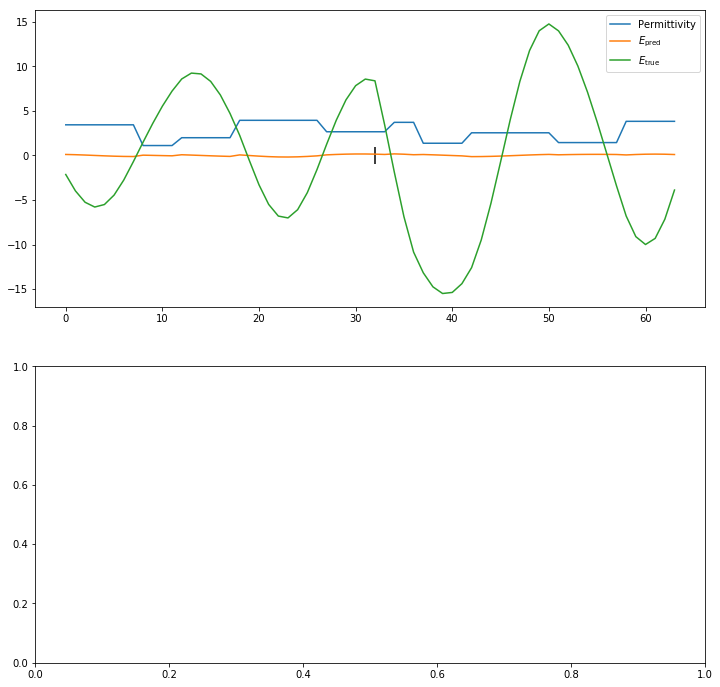

In [30]:
model.eval()
sizes, epsilons = layer_generator()
plot_model_outputs(sizes, epsilons)